## Code testing for datatool.py


In [99]:
import os,sys,json,csv
from datetime import date,timedelta,datetime
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import geopandas
import rasterio
from rasterio.mask import mask
from rasterio import Affine # or from affine import Affine
from shapely.geometry import Point

### load watersheds data

In [100]:
watersheds_gdb = 'Watersheds_032020/wastershed_prj_latlon.shp'
watersheds = geopandas.read_file(watersheds_gdb)
watersheds.rename(columns={"pfaf_id": "aqid"},inplace=True)
watersheds.set_index("aqid",inplace=True)

In [101]:
watersheds

,areakm2,geometry
aqid,,
111011,1888.469,"POLYGON ((32.35221 30.09110, 32.35759 30.08693..."
111012,2922.800,"POLYGON ((31.78710 29.90320, 31.79255 29.89238..."
111013,891.315,"POLYGON ((32.33579 29.62952, 32.34658 29.62634..."
111014,4212.890,"POLYGON ((32.40452 29.27258, 32.41215 29.26492..."
111015,16606.605,"MULTIPOLYGON (((33.99846 26.71211, 33.99590 26..."
...,...,...
914806,4062.425,"POLYGON ((-34.61250 78.59167, -34.62083 78.583..."
914807,2132.735,"POLYGON ((-35.60833 78.57917, -35.67743 78.579..."
914808,4064.658,"POLYGON ((-35.82500 78.58750, -35.82917 78.583..."


In [102]:
watersheds[watersheds.areakm2>100.0]

,areakm2,geometry
aqid,,
111011,1888.469,"POLYGON ((32.35221 30.09110, 32.35759 30.08693..."
111012,2922.800,"POLYGON ((31.78710 29.90320, 31.79255 29.89238..."
111013,891.315,"POLYGON ((32.33579 29.62952, 32.34658 29.62634..."
111014,4212.890,"POLYGON ((32.40452 29.27258, 32.41215 29.26492..."
111015,16606.605,"MULTIPOLYGON (((33.99846 26.71211, 33.99590 26..."
...,...,...
914806,4062.425,"POLYGON ((-34.61250 78.59167, -34.62083 78.583..."
914807,2132.735,"POLYGON ((-35.60833 78.57917, -35.67743 78.579..."
914808,4064.658,"POLYGON ((-35.82500 78.58750, -35.82917 78.583..."


In [103]:
print("Percentage (area>100.0km2)",15941/16396*100.0,"%")

Percentage (area>100.0km2) 97.22493291046597 %


### load GloFAS data

In [104]:
fixed_sites = "data/raw/threspoints_2020050500.txt" 
dyn_sites = "data/raw/threspointsDyn_2020050500.txt"

In [105]:
header_fixed = ["Point No", "ID", "Basin", "Location", "Station", "Country", "Continent", "Country_code", "Upstream area", "unknown_1", "Lon", "Lat", "empty", "unknown_2", "Days until peak", "GloFAS_2yr", "GloFAS_5yr", "GloFAS_20y", "Alert_level"]
fixed_data = pd.read_csv(fixed_sites,header = None, names=header_fixed)
fixed_data

,Point No,ID,Basin,Location,Station,Country,Continent,Country_code,Upstream area,unknown_1,Lon,Lat,empty,unknown_2,Days until peak,GloFAS_2yr,GloFAS_5yr,GloFAS_20y,Alert_level
0,1,2903430,Lena,Lena,Stolb,Russian Federation,Asia,RU,2460000,0,126.75,72.25,-,2,30,0.0392,0.0000,0.0000,0
1,2,2999910,Olenek,Olenek,7 5Km D S Of Mouth Of River Pur,Russian Federation,Asia,RU,198000,0,123.35,72.15,-,3,27,0.2940,0.0196,0.0000,1
2,3,2999850,Khatanga,Khatanga,Khatanga,Russian Federation,Asia,RU,275000,0,102.15,71.95,-,3,30,0.3330,0.0784,0.0000,1
3,4,2999150,Anabar,Anabar,Saskylakh,Russian Federation,Asia,RU,78800,0,114.05,71.95,-,3,30,0.2160,0.0980,0.0196,1
4,5,2903420,Lena,Lena,Kyusyur Kusur,Russian Federation,Asia,RU,2430000,0,127.55,70.85,-,2,30,0.0392,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,2373,5868050,Clutha,Clutha,Clyde,New Zealand,Australia_Oceania,NZ,12018,0,169.35,-45.25,-,2,20,0.0196,0.0196,0.0196,0
2373,2374,11342001,Aisen,Aisen,En Puerto Aysen,Chile,South_America,CL,-9999,0,-72.65,-45.45,-,2,18,0.0980,0.0588,0.0392,0
2374,2375,5868100,Clutha,Clutha,Balclutha,New Zealand,Australia_Oceania,NZ,20582,0,169.75,-46.35,-,2,22,0.0392,0.0196,0.0196,0
2375,2376,11542001,Rio Baker,Rio Baker,En Colonia,Chile,South_America,CL,-9999,0,-72.85,-47.35,-,2,28,0.0196,0.0000,0.0000,0


In [106]:
header_dyn = ["Point No", "ID", "Station", "Basin", "Location", "Country", "Continent", "Country_code", "unknown_1","Upstream area", "Lon", "Lat", "empty", "unknown_2", "Days until peak", "GloFAS_2yr", "GloFAS_5yr", "GloFAS_20y", "Alert_level"]
dyn_data = pd.read_csv(dyn_sites,header=None,names=header_dyn)
dyn_data

,Point No,ID,Station,Basin,Location,Country,Continent,Country_code,unknown_1,Upstream area,Lon,Lat,empty,unknown_2,Days until peak,GloFAS_2yr,GloFAS_5yr,GloFAS_20y,Alert_level
0,2378,1,Dynamic Point,-,-,-,-,-,-,8105.0,127.45,70.85,-,3,30,0.647,0.373,0.1570,1
1,2379,2,Dynamic Point,-,-,-,-,-,-,4748.0,129.55,70.75,-,3,26,0.353,0.235,0.0588,1
2,2380,3,Dynamic Point,-,-,-,-,-,-,2309.0,125.35,70.65,-,3,21,0.471,0.275,0.0784,1
3,2381,4,Dynamic Point,-,-,-,-,-,-,16048.0,-154.15,70.55,-,3,10,0.510,0.216,0.0000,1
4,2382,5,Dynamic Point,-,-,-,-,-,-,63654.0,-150.95,70.45,-,3,17,0.804,0.412,0.0392,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2771,394,Dynamic Point,-,-,-,-,-,-,45964.0,19.05,-16.65,-,0,1,1.000,1.000,0.0000,2
394,2772,395,Dynamic Point,-,-,-,-,-,-,585042.0,27.45,-17.35,-,1,6,1.000,1.000,0.0000,2
395,2773,396,Dynamic Point,-,-,-,-,-,-,56940.0,20.55,-17.85,-,0,1,1.000,1.000,0.0000,2
396,2774,397,Dynamic Point,-,-,-,-,-,-,514302.0,26.15,-17.95,-,1,5,1.000,1.000,0.0000,2


In [107]:
print(list(fixed_data.columns))
print(list(dyn_data.columns))

['Point No', 'ID', 'Basin', 'Location', 'Station', 'Country', 'Continent', 'Country_code', 'Upstream area', 'unknown_1', 'Lon', 'Lat', 'empty', 'unknown_2', 'Days until peak', 'GloFAS_2yr', 'GloFAS_5yr', 'GloFAS_20y', 'Alert_level']
['Point No', 'ID', 'Station', 'Basin', 'Location', 'Country', 'Continent', 'Country_code', 'unknown_1', 'Upstream area', 'Lon', 'Lat', 'empty', 'unknown_2', 'Days until peak', 'GloFAS_2yr', 'GloFAS_5yr', 'GloFAS_20y', 'Alert_level']


In [108]:
# merge two datasets
total_data = fixed_data.append(dyn_data,sort=True)

In [109]:
total_data

,Alert_level,Basin,Continent,Country,Country_code,Days until peak,GloFAS_20y,GloFAS_2yr,GloFAS_5yr,ID,Lat,Location,Lon,Point No,Station,Upstream area,empty,unknown_1,unknown_2
0,0,Lena,Asia,Russian Federation,RU,30,0.0000,0.0392,0.0000,2903430,72.25,Lena,126.75,1,Stolb,2460000.0,-,0,2
1,1,Olenek,Asia,Russian Federation,RU,27,0.0000,0.2940,0.0196,2999910,72.15,Olenek,123.35,2,7 5Km D S Of Mouth Of River Pur,198000.0,-,0,3
2,1,Khatanga,Asia,Russian Federation,RU,30,0.0000,0.3330,0.0784,2999850,71.95,Khatanga,102.15,3,Khatanga,275000.0,-,0,3
3,1,Anabar,Asia,Russian Federation,RU,30,0.0196,0.2160,0.0980,2999150,71.95,Anabar,114.05,4,Saskylakh,78800.0,-,0,3
4,0,Lena,Asia,Russian Federation,RU,30,0.0000,0.0392,0.0000,2903420,70.85,Lena,127.55,5,Kyusyur Kusur,2430000.0,-,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2,-,-,-,-,1,0.0000,1.0000,1.0000,394,-16.65,-,19.05,2771,Dynamic Point,45964.0,-,-,0
394,2,-,-,-,-,6,0.0000,1.0000,1.0000,395,-17.35,-,27.45,2772,Dynamic Point,585042.0,-,-,1
395,2,-,-,-,-,1,0.0000,1.0000,1.0000,396,-17.85,-,20.55,2773,Dynamic Point,56940.0,-,-,0
396,2,-,-,-,-,5,0.0000,1.0000,1.0000,397,-17.95,-,26.15,2774,Dynamic Point,514302.0,-,-,1


In [110]:
# create a geopanda dataset
gdf = geopandas.GeoDataFrame(
    total_data, geometry=geopandas.points_from_xy(total_data.Lon, total_data.Lat))
gdf.crs = "EPSG:4326"

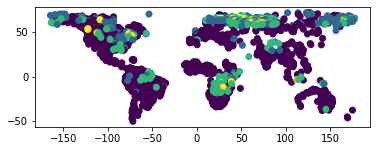

In [111]:
gdf.plot(column='Alert_level')

### Assign GloFAS entry with watersheds

In [112]:
# generate sindex
gdf.sindex
watersheds.sindex

In [113]:
# sjoin 
watersheds.crs = "EPSG:4326"
gdf_watersheds = geopandas.sjoin(gdf, watersheds, op='within')

In [114]:
gdf_watersheds.rename(columns={"index_right":"pfaf_id"},inplace=True)

In [115]:
gdf_watersheds

,Alert_level,Basin,Continent,Country,Country_code,Days until peak,GloFAS_20y,GloFAS_2yr,GloFAS_5yr,ID,...,Lon,Point No,Station,Upstream area,empty,unknown_1,unknown_2,geometry,pfaf_id,areakm2
0,0,Lena,Asia,Russian Federation,RU,30,0.0000,0.0392,0.0000,2903430,...,126.75,1,Stolb,2460000.0,-,0,2,POINT (126.75000 72.25000),342111,12470.232
1,1,Olenek,Asia,Russian Federation,RU,27,0.0000,0.2940,0.0196,2999910,...,123.35,2,7 5Km D S Of Mouth Of River Pur,198000.0,-,0,3,POINT (123.35000 72.15000),331810,21520.770
2,1,Khatanga,Asia,Russian Federation,RU,30,0.0000,0.3330,0.0784,2999850,...,102.15,3,Khatanga,275000.0,-,0,3,POINT (102.15000 71.95000),331630,4772.068
3,1,Anabar,Asia,Russian Federation,RU,30,0.0196,0.2160,0.0980,2999150,...,114.05,4,Saskylakh,78800.0,-,0,3,POINT (114.05000 71.95000),331761,11913.820
4,0,Lena,Asia,Russian Federation,RU,30,0.0000,0.0392,0.0000,2903420,...,127.55,5,Kyusyur Kusur,2430000.0,-,0,2,POINT (127.55000 70.85000),342115,8836.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2,-,-,-,-,1,0.0000,1.0000,1.0000,394,...,19.05,2771,Dynamic Point,45964.0,-,-,0,POINT (19.05000 -16.65000),129603,1747.569
394,2,-,-,-,-,6,0.0000,1.0000,1.0000,395,...,27.45,2772,Dynamic Point,585042.0,-,-,1,POINT (27.45000 -17.35000),122770,19746.823
395,2,-,-,-,-,1,0.0000,1.0000,1.0000,396,...,20.55,2773,Dynamic Point,56940.0,-,-,0,POINT (20.55000 -17.85000),129601,9379.207
396,2,-,-,-,-,5,0.0000,1.0000,1.0000,397,...,26.15,2774,Dynamic Point,514302.0,-,-,1,POINT (26.15000 -17.95000),122790,21825.803


In [116]:
#fixed_sites = "data/raw/threspoints_2020050500.txt" 
forcast_time = (fixed_sites.split("_")[1]).replace('00.txt','')
forcast_time = datetime.strptime(forcast_time, '%Y%m%d' )
forcast_time.isoformat()

'2020-05-05T00:00:00'

In [117]:
# add column "Forecast Date"
gdf_watersheds["Forecast Date"]=forcast_time.isoformat()
gdf_watersheds.columns

Index(['Alert_level', 'Basin', 'Continent', 'Country', 'Country_code',
       'Days until peak', 'GloFAS_20y', 'GloFAS_2yr', 'GloFAS_5yr', 'ID',
       'Lat', 'Location', 'Lon', 'Point No', 'Station', 'Upstream area',
       'empty', 'unknown_1', 'unknown_2', 'geometry', 'pfaf_id', 'areakm2',
       'Forecast Date'],
      dtype='object')

In [120]:
# write out csv file
out_csv = "data/glofas/threspoints_2020050500.csv"
out_columns =['Point No',"Station","Basin","Country","Lat","Lon","Upstream area","Forecast Date",
             "GloFAS_2yr","GloFAS_5yr","GloFAS_20y","Days until peak","pfaf_id"]
gdf_watersheds.to_csv(out_csv,index=False,columns=out_columns,float_format='%.3f')

In [119]:
# write to excel
out_excel = "data/glofas/threspoints_2020050500.xlsx"
gdf_watersheds.to_excel(out_excel,index=False,columns=out_columns,sheet_name='Sheet_name_1')